In [2]:
!pip3 install igraph
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.4 MB/s eta 0:00:00


In [3]:
!pip install scanpy
!pip install statsmodels
import scanpy as sc
import statsmodels.api as sm
import numpy as np
import pandas as pd


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.8 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=0d92f4f4b90eff7105a78aa40c68a82d08a7fa97b71f49f8f1f0288ab59d6ea1
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [4]:
# Load the dataset
adata = sc.read('dataset.h5ad')


In [5]:
# Load gene names
gene_names_df = pd.read_csv('gene_names.csv', header=None)
gene_names = gene_names_df[0].tolist()

In [6]:
# Check dimensions
print("Number of genes in adata:", len(adata.var_names))
print("Number of gene names loaded:", len(gene_names))

Number of genes in adata: 12303
Number of gene names loaded: 12304


In [7]:
# Ensure gene names match the number of genes in adata
if len(gene_names) > len(adata.var_names):
    gene_names = gene_names[:len(adata.var_names)]

# Create a mapping of gene names to adata.var
if len(gene_names) == len(adata.var_names):
    adata.var['gene_names'] = gene_names
else:
    print("Warning: Gene names list length does not match dataset length. Check the data.")


In [8]:
# Quality Control (QC)
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Filter cells with more than 200 genes and less than 25000 total counts
adata = adata[adata.obs['n_genes_by_counts'] > 200, :]
adata = adata[adata.obs['total_counts'] < 25000, :]

# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
def calculate_deviance(X, y):
    # Fit a GLM model
    model = sm.GLM(y, X, family=sm.families.Poisson())
    result = model.fit()
    return result.deviance

# Assuming 'X' is the cell data and 'y' is the gene expression data
X = np.ones((adata.n_obs, 1))  # Intercept (or other covariates if needed)
deviances = []

for gene in range(adata.shape[1]):
    y = adata[:, gene].X.toarray().flatten()  # Gene expression for each cell
    dev = calculate_deviance(X, y)
    deviances.append(dev)

# Sort genes by deviance and select top N genes
top_genes_indices = np.argsort(deviances)[:2000]
adata = adata[:, top_genes_indices]


In [11]:
# PCA
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)

# Clustering using Leiden Method
sc.tl.leiden(adata, resolution=1.0)  


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
<ipython-input-11-e353d6ea96a0>:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0)  # Adjust resolution parameter as needed


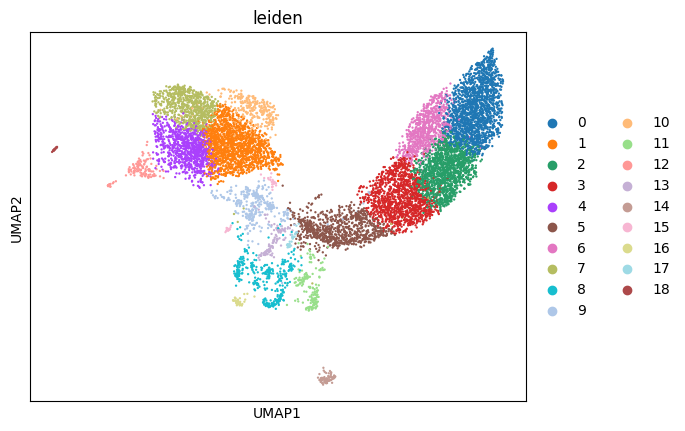

In [13]:
# Calculate UMAP representation
sc.tl.umap(adata)

# Visualization of Clusters
sc.pl.umap(adata, color=['leiden'])
